In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import warnings

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    auc,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    cohen_kappa_score,
    log_loss
)
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (8,5)
RANDOM_STATE = 42

print("Loading data...")
X_train = np.load("../data/processed/X_train.npy")
X_test = np.load("../data/processed/X_test.npy")
y_train = np.load("../data/processed/y_train.npy")
y_test = np.load("../data/processed/y_test.npy")

class_names = ["Normal", "DoS", "Probe", "Privilege"]

print("Data loaded successfully.")
print("Test shape:", X_test.shape)

Loading data...
Data loaded successfully.
Test shape: (22544, 80)


In [10]:
print("Loading saved models and optimal thresholds...")

# 1. Load meta learner
meta_model = tf.keras.models.load_model("../outputs/models/meta_model_ultimate.keras")
print("✅ Keras Meta-Learner loaded.")

# 2. Load base models
base_models = joblib.load("../outputs/models/fast_base_models.pkl")
print("✅ Fast Base Models loaded.")

# 3. Load class weights
class_weights = joblib.load("../outputs/models/ultimate_class_weights.pkl")
print("✅ Amplified Class Weights loaded.")

# 4. Load threshold multiplier
threshold_data = joblib.load("../outputs/models/optimal_thresholds.pkl")
class_3_multiplier = threshold_data.get('class_3_multiplier', 1.0)
print(f"✅ Optimal Class 3 Multiplier loaded: {class_3_multiplier}x")

Loading saved models and optimal thresholds...
✅ Keras Meta-Learner loaded.
✅ Fast Base Models loaded.
✅ Amplified Class Weights loaded.
✅ Optimal Class 3 Multiplier loaded: 1.0x


In [11]:
print("\nGenerating meta features (FAST mode)...")

n_classes = len(np.unique(y_train))
n_models = len(base_models)

X_meta_test = np.zeros((X_test.shape[0], n_models * n_classes))

# Train each base model on the FULL training set before evaluating on Test
for i, model in enumerate(base_models):
    print(f"Fitting base model {i+1}/{n_models} ({model.__class__.__name__})...")
    
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)
    
    X_meta_test[:, i*n_classes:(i+1)*n_classes] = probs

print("Meta features ready:", X_meta_test.shape)


Generating meta features (FAST mode)...
Fitting base model 1/4 (KNeighborsClassifier)...
Fitting base model 2/4 (DecisionTreeClassifier)...
Fitting base model 3/4 (LogisticRegression)...
Fitting base model 4/4 (RandomForestClassifier)...
Meta features ready: (22544, 16)


In [12]:
print("\nGenerating final predictions with optimized threshold...")

# Raw probabilities
y_pred_proba_raw = meta_model.predict(X_meta_test, verbose=0)

# Apply multiplier
y_pred_proba_adjusted = y_pred_proba_raw.copy()
y_pred_proba_adjusted[:, 3] *= class_3_multiplier

# ⭐ PROFESSIONAL FIX: renormalize probabilities
y_pred_proba_adjusted = (
    y_pred_proba_adjusted /
    y_pred_proba_adjusted.sum(axis=1, keepdims=True)
)

# Final predictions
y_pred_meta = np.argmax(y_pred_proba_adjusted, axis=1)

print("Predictions successfully generated.")


Generating final predictions with optimized threshold...
Predictions successfully generated.


In [18]:
print("\n" + "="*45)
print("🏆 ADVANCED EVALUATION METRICS (LEAK-FREE)")
print("="*45)

acc = accuracy_score(y_test, y_pred_meta)
prec = precision_score(y_test, y_pred_meta, average='macro')
rec = recall_score(y_test, y_pred_meta, average='macro')
f1 = f1_score(y_test, y_pred_meta, average='macro')

ll = log_loss(y_test, y_pred_proba_raw)
mcc = matthews_corrcoef(y_test, y_pred_meta)
kappa = cohen_kappa_score(y_test, y_pred_meta)

print(f"Accuracy:               {acc:.5f}")
print(f"Precision (Macro):      {prec:.5f}")
print(f"Recall (Macro):         {rec:.5f}")
print(f"F1 Score (Macro):       {f1:.5f}")
print("-" * 45)
print(f"Log Loss:               {ll:.5f}")
print(f"Cohen's Kappa:          {kappa:.5f}")
print(f"⭐ Matthews Corrcoef:    {mcc:.5f}  <-- (Key Metric!)")
print("="*45)



🏆 ADVANCED EVALUATION METRICS (LEAK-FREE)
Accuracy:               0.83601
Precision (Macro):      0.86241
Recall (Macro):         0.76199
F1 Score (Macro):       0.79068
---------------------------------------------
Log Loss:               1.41633
Cohen's Kappa:          0.74814
⭐ Matthews Corrcoef:    0.76038  <-- (Key Metric!)


In [14]:
print("\nClassification Report:\n")

report_dict = classification_report(
    y_test,
    y_pred_meta,
    target_names=class_names,
    output_dict=True
)

print(classification_report(y_test, y_pred_meta, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
display(report_df)


Classification Report:

              precision    recall  f1-score   support

      Normal       0.76      0.96      0.85      9711
         DoS       0.96      0.83      0.89      7458
       Probe       0.83      0.79      0.81      2421
   Privilege       0.89      0.46      0.61      2954

    accuracy                           0.84     22544
   macro avg       0.86      0.76      0.79     22544
weighted avg       0.85      0.84      0.83     22544



,precision,recall,f1-score,support
Normal,0.762909,0.964576,0.851971,9711.00000
DoS,0.964258,0.831992,0.893256,7458.00000
Probe,0.830082,0.790995,0.810068,2421.00000
Privilege,0.892388,0.460393,0.607414,2954.00000
accuracy,0.836010,0.836010,0.836010,0.83601
macro avg,0.862410,0.761989,0.790677,22544.00000
weighted avg,0.853699,0.836010,0.829084,22544.00000


<Figure size 700x600 with 0 Axes>

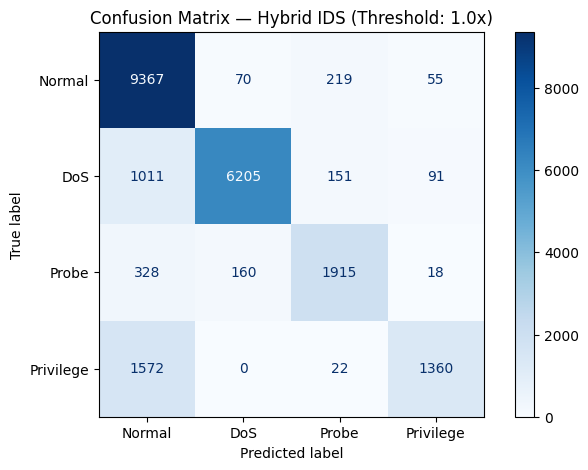

In [15]:
cm = confusion_matrix(y_test, y_pred_meta, labels=[0,1,2,3])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

plt.figure(figsize=(7,6))
disp.plot(cmap="Blues", values_format='d')
plt.title(f"Confusion Matrix — Hybrid IDS (Threshold: {class_3_multiplier}x)")
plt.show()

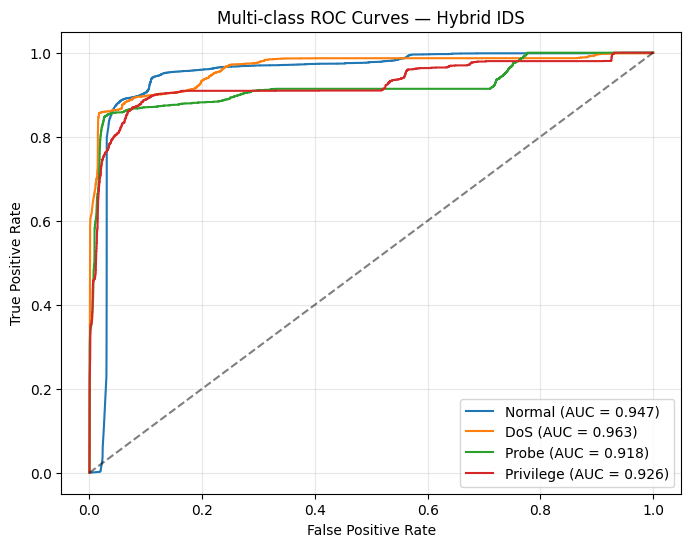

In [16]:
y_test_bin = label_binarize(y_test, classes=[0,1,2,3])

plt.figure(figsize=(8,6))

for i, label in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba_raw[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curves — Hybrid IDS")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Training analysis Random Forest (Fast)...


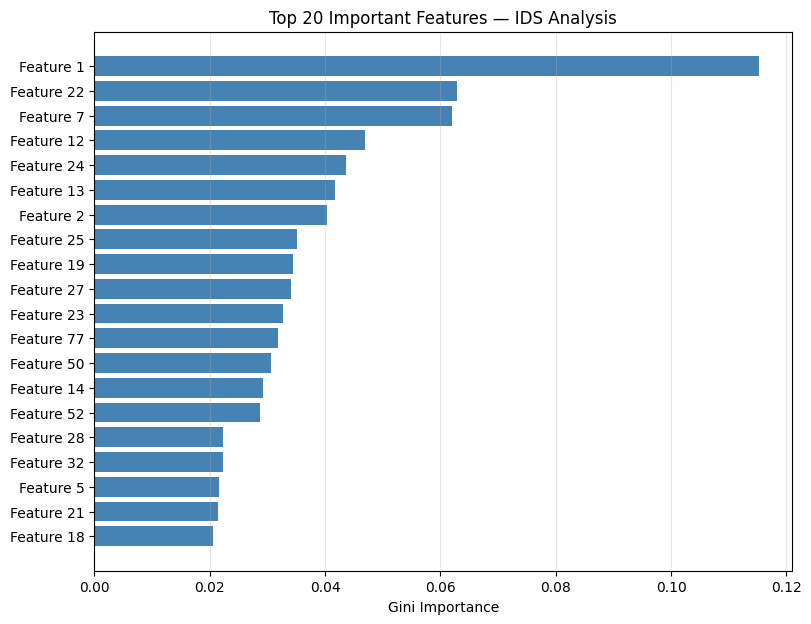

In [17]:
print("Training analysis Random Forest (Fast)...")

rf_analysis = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=3,
    min_samples_leaf=1,
    class_weight=class_weights,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_analysis.fit(X_train, y_train)

importances = rf_analysis.feature_importances_
indices = np.argsort(importances)[-20:]

plt.figure(figsize=(9,7))
plt.barh(range(len(indices)), importances[indices], color='steelblue')
plt.yticks(range(len(indices)), [f"Feature {i}" for i in indices])
plt.xlabel("Gini Importance")
plt.title("Top 20 Important Features — IDS Analysis")
plt.grid(axis='x', alpha=0.3)
plt.show()